In [2]:
%matplotlib widget

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.animation import FuncAnimation
import numpy as np
import datetime

In [4]:
df = pd.read_csv('cleaned_data.csv', index_col = 0)

In [5]:
# convert to datetime
df['BEGIN_DATE_TIME'] = df['BEGIN_DATE_TIME'].apply(lambda x: datetime.datetime.strptime(x, '%d-%b-%y %H:%M:%S'))

In [6]:
def scatter_all_event_types(df):
    event_types = df['EVENT_TYPE'].unique()
    fig, ax = plt.subplots(figsize=(15,5))
    for event_type in event_types:
        subset = df[df['EVENT_TYPE'] == event_type].dropna(subset=['LATITUDE'])
        if len(subset) > 0:
            ax.scatter(subset['LONGITUDE'].values, subset['LATITUDE'].values, marker='.', label=event_type)
    plt.legend()
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')
    return fig, ax

(<Figure size 1500x500 with 1 Axes>,
 <AxesSubplot:xlabel='longitude', ylabel='latitude'>)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
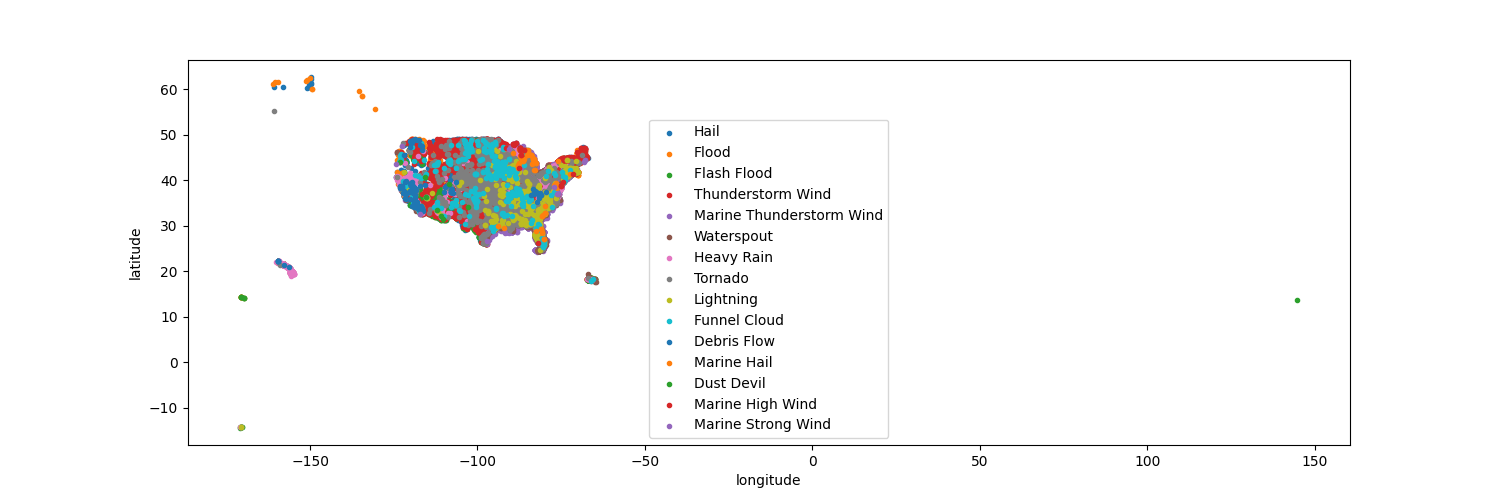

In [7]:
scatter_all_event_types(df)

## animate 2018

In [8]:
df2018 = df[df['BEGIN_DATE_TIME'] > datetime.datetime.strptime('2014', '%Y')].dropna(subset=['LATITUDE'])

In [9]:
# create color mapping
cmap = plt.get_cmap('tab20').colors
color_mapper = {event_type: cmap[i] for i, event_type in enumerate(df2018['EVENT_TYPE'].unique())}
legend_patches = []
for event_type, color in color_mapper.items():
    legend_patches.append(mpatches.Patch(color=color, label=event_type))

In [10]:
def get_month_day(row_index):
    date_time = df2018.loc[row_index, 'BEGIN_DATE_TIME']
    return date_time.month, date_time.day

In [11]:
groups = df2018.groupby(get_month_day)

In [12]:
groups = [group for group in groups]

MovieWriter ffmpeg unavailable; using Pillow instead.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
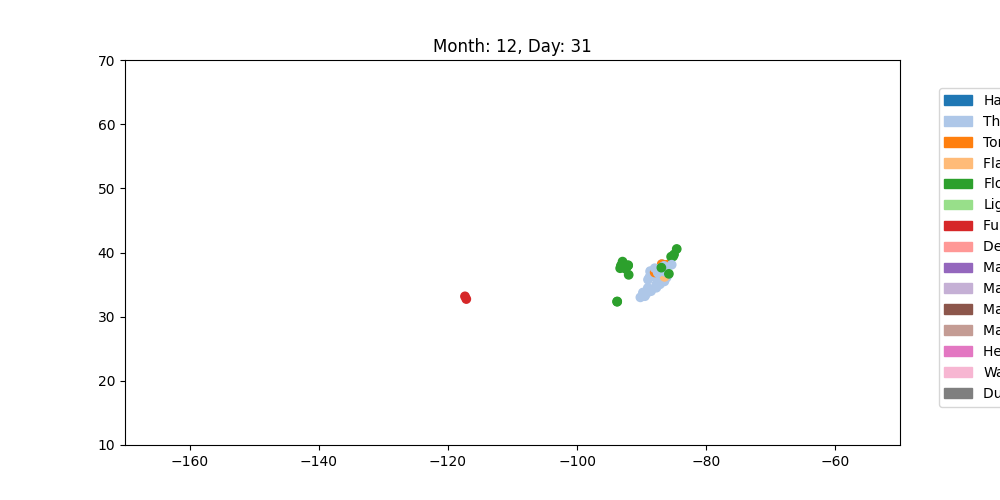

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_xlim((-170, -50))
ax.set_ylim((10, 70))

(month, day), df_ = groups[0]
scat = ax.scatter(df_['LONGITUDE'].values, df_['LATITUDE'].values, c=df_['EVENT_TYPE'].map(color_mapper))
title = ax.set_title(f'Month: {month}, Day: {day}')

import matplotlib.pyplot as plt

plt.legend(handles=legend_patches, loc=(1.05,.1))

def animate(group_num):
    (month, day), df_ = groups[group_num]
    scat.set_offsets(np.array([df_['LONGITUDE'].values, df_['LATITUDE'].values]).T)
    scat.set_color(df_['EVENT_TYPE'].map(color_mapper).values)
    title.set_text(f'Month: {month}, Day: {day}')
     
ani = FuncAnimation(fig=fig, func=animate, frames=len(groups), interval=10, repeat=True)
ani.save('animap.gif')

# compare 2005 to 2018

In [18]:
from sklearn.neighbors import KernelDensity

In [19]:
kder = KernelDensity()

In [144]:
df2005 = df[df['BEGIN_DATE_TIME'] < datetime.datetime.strptime('2014', '%Y')]
df2018 = df[df['BEGIN_DATE_TIME'] > datetime.datetime.strptime('2014', '%Y')]
df2005['BEGIN_DATE_TIME'] = df2005['BEGIN_DATE_TIME'].apply(lambda x: x + datetime.timedelta(days=13*365+3))

/Users/ek/miniconda3/envs/get_NOAA/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
base_date = min(df2018['BEGIN_DATE_TIME'])
datetime_line = np.array([base_date + datetime.timedelta(days=x) for x in range(365)]).reshape(-1,1).astype(df2005['BEGIN_DATE_TIME'].dtype)

In [22]:
groups2018 = {name: df for name, df_ in df2018.groupby('EVENT_TYPE')}

In [98]:
import matplotlib.dates as mdates
def plot_time_kde_comparison(df_2005, df_2018):
    groups2018 = {name: df_ for name, df_ in df_2018.groupby('EVENT_TYPE')}
    groups2005 = {name: df_ for name, df_ in df_2005.groupby('EVENT_TYPE')}
    bad_keys = []
    for key in groups2005.keys():
        if key not in groups2018:
            bad_keys.append(key)
    for bad_key in bad_keys:
        del groups2005[bad_key]
        
    bad_keys=[]
    for key in groups2018.keys():
        if key not in groups2005:
            bad_keys.append(key)
    for bad_key in bad_keys:
        del groups2018[bad_key]
            
    fig, axes = plt.subplots(int(round(len(groups2005)/3)), 3, sharex=True, sharey=True, figsize=(9,2*round(len(groups2005)/3)))
    fig.suptitle('probability of events for 2005 compared to 2018')
    axes = axes.flatten()
    
    for i, event_type in enumerate(groups2005.keys()):
        ax = axes[i]
        ax.set_title(event_type)
        
        kder = KernelDensity(bandwidth=1e+15)
        kder.fit(groups2005[event_type]['BEGIN_DATE_TIME'].values.reshape(-1,1))
        _2005_density = np.exp(kder.score_samples(datetime_line))
        kder = KernelDensity(bandwidth=1e+15)
        kder.fit(groups2018[event_type]['BEGIN_DATE_TIME'].values.reshape(-1,1))
        _2018_density = np.exp(kder.score_samples(datetime_line))
        
        ax.plot(datetime_line, _2005_density, ls=':', label='2005')
        ax.plot(datetime_line, _2018_density, label='2018')

    for ax in axes[-3:]:
        ax.set_xticklabels(ax.get_xticks(), rotation = 90)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
    axes[0].legend()
    return fig, axes

/Users/ek/miniconda3/envs/get_NOAA/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator


(<Figure size 900x2600 with 39 Axes>,
 array([<AxesSubplot:title={'center':'Avalanche'}>,
        <AxesSubplot:title={'center':'Blizzard'}>,
        <AxesSubplot:title={'center':'Coastal Flood'}>,
        <AxesSubplot:title={'center':'Cold/Wind Chill'}>,
        <AxesSubplot:title={'center':'Debris Flow'}>,
        <AxesSubplot:title={'center':'Dense Fog'}>,
        <AxesSubplot:title={'center':'Drought'}>,
        <AxesSubplot:title={'center':'Dust Devil'}>,
        <AxesSubplot:title={'center':'Dust Storm'}>,
        <AxesSubplot:title={'center':'Flash Flood'}>,
        <AxesSubplot:title={'center':'Flood'}>,
        <AxesSubplot:title={'center':'Freezing Fog'}>,
        <AxesSubplot:title={'center':'Frost/Freeze'}>,
        <AxesSubplot:title={'center':'Funnel Cloud'}>,
        <AxesSubplot:title={'center':'Hail'}>,
        <AxesSubplot:title={'center':'Heat'}>,
        <AxesSubplot:title={'center':'Heavy Rain'}>,
        <AxesSubplot:title={'center':'Heavy Snow'}>,
        <AxesSub

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
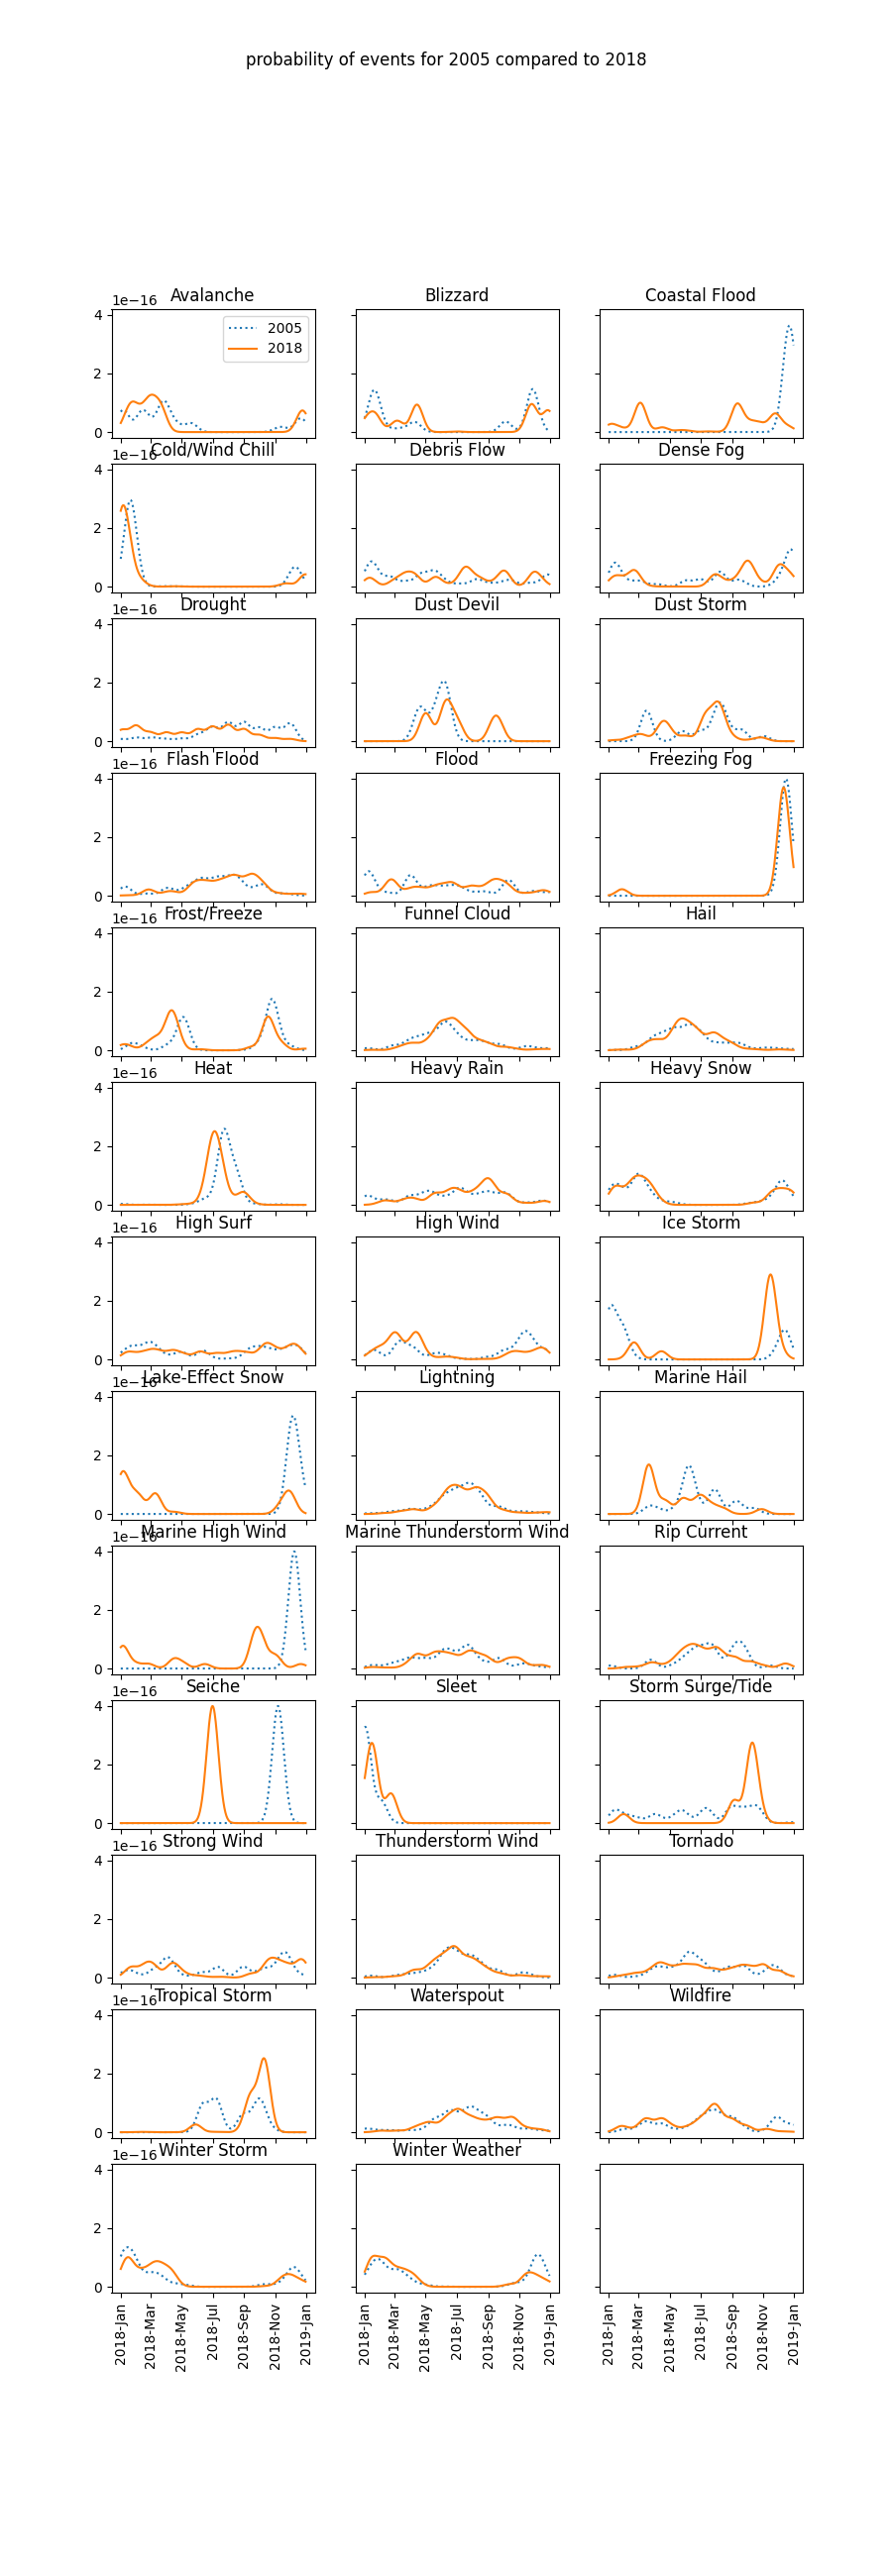

In [99]:
plot_time_kde_comparison(df2005, df2018)

In [150]:
df_cluster = df2018.copy().dropna()

In [152]:
for column in df_cluster.columns:
    if column.startswith('DAMAGE'):
        df_cluster[column] = df_cluster[column].apply(lambda x: float(x[:-1]))

## Try clustering

In [157]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA

In [158]:
clusterer = MiniBatchKMeans(3)
pca = PCA(2)

In [159]:
input_data = df_cluster[['INJURIES_INDIRECT', 'DEATHS_DIRECT','DEATHS_INDIRECT', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'LATITUDE', 'LONGITUDE']].values

In [160]:
clusterer.fit(input_data)

MiniBatchKMeans(n_clusters=3)

In [163]:
df_cluster['CLUSTER'] = clusterer.predict(input_data)

In [164]:
pca.fit(input_data)

PCA(n_components=2)

In [166]:
pcomps = pca.transform(input_data)

In [169]:
*pcomps.T

SyntaxError: can't use starred expression here (1571652802.py, line 4)

Text(0, 0.5, 'PC2')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
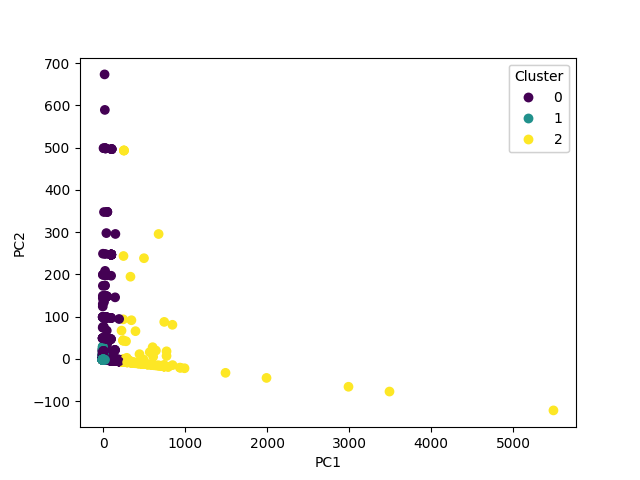

In [178]:
fig, ax = plt.subplots()

scatter = ax.scatter(*pcomps.T, c= df_cluster['CLUSTER'].values)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Cluster")
ax.add_artist(legend1)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

In [173]:
df_cluster.groupby('CLUSTER').mean()

,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,LATITUDE,LONGITUDE
CLUSTER,,,,,,,,
0,0.014605,0.001296,0.004122,0.000824,7.242025,1.516717,38.110572,-98.516213
1,0.009744,0.000298,0.005207,0.000446,1.529078,0.068924,37.296997,-80.976113
2,0.718978,0.007299,0.102190,0.007299,463.800949,12.974453,38.148007,-91.596842


### Cluster 2 is the most dangerous one. Does this have a spatial tendency or a disaster type one?

In [187]:
def scatter_clusters_on_map(df):
    fig, ax = plt.subplots(figsize=(5,5))
    ax.scatter(df['LONGITUDE'].values, df['LATITUDE'].values, marker='.', c=df['CLUSTER'])
    plt.legend()
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')
    return fig, ax

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(<Figure size 500x500 with 1 Axes>,
 <AxesSubplot:xlabel='longitude', ylabel='latitude'>)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
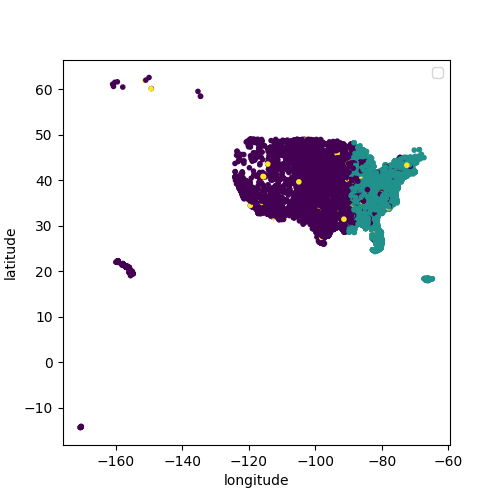

In [188]:
scatter_clusters_on_map(df_cluster)

## Clusters 0 and 1 are spatial clusters, the algorithm seperated east and west coast disasters. Cluster 2 seems to be the most disastrous events from anywhere. What kind of events are these?

In [200]:
bars = df_cluster['EVENT_TYPE'].unique()
cluster2_type_counts = dict(df_cluster[df_cluster['CLUSTER'] == 2].groupby('EVENT_TYPE')['EVENT_TYPE'].count())


In [201]:
counts = {}
for type_ in bars:
    if type_ in cluster2_type_counts:
        counts[type_] = cluster2_type_counts[type_]
    else:
        counts[type_] = 0

Text(0.5, 1.0, 'Event type frequency in the high damage cluster')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
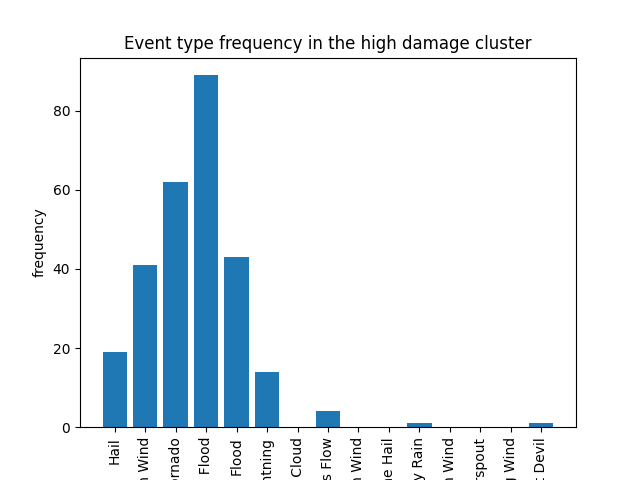

In [209]:
fig, ax = plt.subplots()

ax.bar(list(counts.keys()), list(counts.values()))
plt.xticks(rotation=90)
ax.set_ylabel('frequency')
ax.set_xlabel('disaster type')
ax.set_title('Event type frequency in the high damage cluster')